# Lab 3 - Fine-Tuning vs. From-Scratch Training for Text Classification

### Importing the dataset and data exploration

The AG News dataset is used for this assignment

In [1]:
import numpy as np

In [2]:
from datasets import load_dataset
ds = load_dataset("ag_news")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
train_full = ds["train"]
test_full  = ds["test"]

print(train_full)
print(test_full)

print("\nDisplay a few samples:")
for i in range(5):
    print("\n", train_full[np.random.randint(train_full.num_rows)])

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 7600
})

Display a few samples:

 {'text': 'Nortel Warns of Weaker Sales  OTTAWA (Reuters) - Retreating from an upbeat forecast it  made just last month, Nortel Networks Corp. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=NT.TO target=/stocks/quickinfo/fullquote"&gt;NT.TO&lt;/A&gt; warned on  Thursday that third-quarter sales will fall below  second-quarter levels and that its 2004 revenue growth rate  will lag that of the telecoms-equipment sector as a whole.', 'label': 2}

 {'text': 'Nikkei Up Over 1 Percent at Midday The Nikkei stock average rose 1.02 percent by midsession on Monday as investors were encouraged to seek bargains by a recovery in US stocks after crude oil prices retreated from record highs.', 'label': 2}

 {'text': 'Malaysia #39;s Abdullah Says Islamic Nations Should Rebuild Iraq Malaysian Prime Minister Abdullah Ahmad Badawi 

In [4]:
from collections import Counter

label_names = train_full.features["label"].names
print("Label names:", label_names)

train_label_counts = Counter(train_full["label"])
test_label_counts  = Counter(test_full["label"])

print("\nTrain label counts:")
for idx, name in enumerate(label_names):
    print(f"  {idx} - {name}: {train_label_counts[idx]}")

print("\nTest label counts:")
for idx, name in enumerate(label_names):
    print(f"  {idx} - {name}: {test_label_counts[idx]}")

Label names: ['World', 'Sports', 'Business', 'Sci/Tech']

Train label counts:
  0 - World: 30000
  1 - Sports: 30000
  2 - Business: 30000
  3 - Sci/Tech: 30000

Test label counts:
  0 - World: 1900
  1 - Sports: 1900
  2 - Business: 1900
  3 - Sci/Tech: 1900


- the classes are perfectly balanced in this dataset

Let's split the data into train, validation and test sets using stratification to keep the class ratio (though it could just be random since the classes are well-balanced)

In [5]:
split = train_full.train_test_split(
    test_size=0.1,
    stratify_by_column="label",
    seed=99,
)

train_raw = split["train"]
val_raw   = split["test"]
test_raw  = test_full  # keep HF test as final test set

print("Sizes:")
print("  train:", len(train_raw))
print("  val:  ", len(val_raw))
print("  test: ", len(test_raw))

Sizes:
  train: 108000
  val:   12000
  test:  7600


In [6]:
print("train label counts:", Counter(train_raw["label"]))
print("val label counts:  ", Counter(val_raw["label"]))
print("test label counts: ", Counter(test_raw["label"]))

train label counts: Counter({0: 27000, 1: 27000, 2: 27000, 3: 27000})
val label counts:   Counter({3: 3000, 1: 3000, 0: 3000, 2: 3000})
test label counts:  Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


In [7]:
import statistics

def text_length_stats(ds, name):
    lengths = [len(example["text"].split()) for example in ds]
    print(f"{name}:")
    print("  N samples:", len(lengths))
    print("  min words:", min(lengths))
    print("  max words:", max(lengths))
    print("  mean words:", round(statistics.mean(lengths), 1))
    print("  median words:", statistics.median(lengths))

text_length_stats(train_raw, "Train")
text_length_stats(val_raw,   "Val")
text_length_stats(test_raw,  "Test")

Train:
  N samples: 108000
  min words: 8
  max words: 177
  mean words: 37.8
  median words: 37.0
Val:
  N samples: 12000
  min words: 8
  max words: 151
  mean words: 37.9
  median words: 37.0
Test:
  N samples: 7600
  min words: 11
  max words: 137
  mean words: 37.7
  median words: 37.0


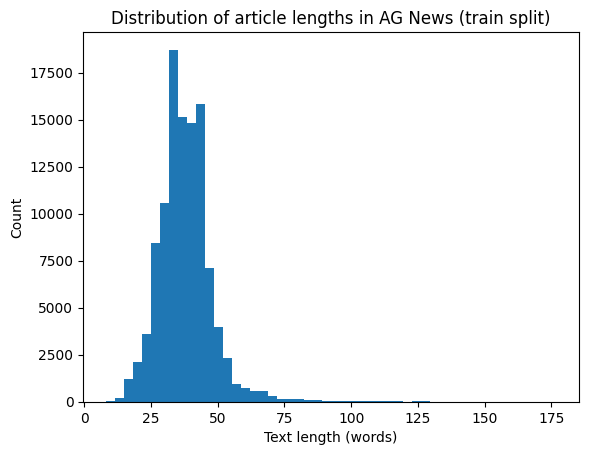

In [8]:
import matplotlib.pyplot as plt

lengths_train = [len(example["text"].split()) for example in train_raw]
plt.hist(lengths_train, bins=50)
plt.xlabel("Text length (words)")
plt.ylabel("Count")
plt.title("Distribution of article lengths in AG News (train split)")
plt.show()

## Dataset Tokenization

**Tokenisation, padding and truncation**

For both models I used the GPT-2 byte-pair encoding tokenizer (`GPT2TokenizerFast`) with a vocabulary size of 50 257. Since GPT-2 does not define a padding token, the pad token was set to the EOS token.

All texts were tokenised and mapped to a fixed **sequence length of 128 tokens** using:
- texts longer than 128 tokens were **clipped** to the first 128 tokens,
- shorter texts were **padded** with the pad token up to length 128.

The resulting input_ids and corresponding attention_mask (1 for real tokens, 0 for padding) are used by both the fine-tuned and from-scratch models. Padding positions are ignored by the model via the attention mask.

**Why like this?**
- most text lengths are around 38 words - and the majority fall under 50 words
- since available tokenizers (like GPT-2’s BPE tokenizer) typically need around 1.5 tokens / word (just an estimate)
    - 1.5 * 50 = 75 tokens
- I will assume the sequence of 128 to be sufficient for each sample  

In [9]:
from transformers import GPT2TokenizerFast
from torch.utils.data import DataLoader

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token   # GPT-2 has no pad token by default and we need it for masking the input samples - shorter ones get padded so that all have a fixed length
MAX_LEN = 128

print("Vocab size:", tokenizer.vocab_size)
print("Pad token id:", tokenizer.pad_token_id)

Vocab size: 50257
Pad token id: 50256


In [10]:
# tokenize splits
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],          # a LIST of raw text strings
        truncation=True,        # cut off sequences longer than max_length
        padding="max_length",   # pad all sequences in batch to length MAX_LEN
        max_length=MAX_LEN,     # the chosen sequence length
    )

train_tok = train_raw.map(tokenize_batch, batched=True)
val_tok   = val_raw.map(tokenize_batch, batched=True)
test_tok  = test_raw.map(tokenize_batch, batched=True)

cols = ["input_ids", "attention_mask", "label"]
for ds_tok in (train_tok, val_tok, test_tok):
    ds_tok.set_format(type="torch", columns=cols)

# dataloaders for from-scratch model
train_loader = DataLoader(train_tok, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_tok, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_tok, batch_size=64, shuffle=False)

batch = next(iter(train_loader))
print("Batch shapes:")
print("  input_ids:      ", batch["input_ids"].shape)      # (B, 128)
print("  attention_mask: ", batch["attention_mask"].shape) # (B, 128)
print("  labels:         ", batch["label"].shape)          # (B,)

Batch shapes:
  input_ids:       torch.Size([16, 128])
  attention_mask:  torch.Size([16, 128])
  labels:          torch.Size([16])


# Fine-tuning GPT-2 as a classifier

- At first "gpt2" was used but for cpu and the whole training dataset it yealded 40h worth of training for one epoch on cpu
- it was therefore changed to `distilgpt2` since it has less parameters
- the training dataset used was also restricted to a **subset of 5k samples** (can be increased if run on gpu)

In [54]:
import time
import numpy as np
import torch
import evaluate
from transformers import (
    GPT2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

# model config
model_name = "distilgpt2"   # smaller, faster than full gpt2
# model_name = "gpt2"

num_labels = len(train_full.features["label"].names)
label_names = train_full.features["label"].names
print("Labels:", label_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# metrics calculations - accuracy + macro F1
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1_macro = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="macro"
    )["f1"]
    return {"accuracy": acc, "f1_macro": f1_macro}

Labels: ['World', 'Sports', 'Business', 'Sci/Tech']
Using device: cpu


In [55]:
# load pre-trained GPT-2 for sequence classification
model_ft = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

# use the same pad token as in the tokenizer
model_ft.config.pad_token_id = tokenizer.pad_token_id

model_ft.to(device)

# count trainable vs total parameters
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total params:      81915648
Trainable params:  81915648


### Model architecture and config

In [57]:
print(model_ft)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=4, bias=False)
)


In [58]:
print(model_ft.config)

GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": 

In [13]:
training_args = TrainingArguments(
    output_dir="checkpoints/gpt2_full",
    eval_strategy="epoch",       # eval at end of each epoch
    save_strategy="epoch",             # save checkpoint each epoch
    learning_rate=5e-5,                # smaller LR for fine-tuning
    per_device_train_batch_size=4,     # small per-device batch
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,     # effective train batch size ≈ 4*4 = 16
    num_train_epochs=5,                # we will likely stop earlier via ES
    weight_decay=0.01,                 # L2 regularization
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,
    save_total_limit=2,
    report_to="none",                  # disable wandb etc.
)

In [14]:
# set a smaller training subset to keep runtime reasonable
N_TRAIN = 5000
train_tok_small = train_tok.select(range(N_TRAIN))
print("Train subset size:", len(train_tok_small))


trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_tok_small,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

Train subset size: 5000


In [15]:
# train and measure training time
start_train = time.time()
train_result = trainer.train()
end_train = time.time()
ft_train_time = end_train - start_train
print(f"Fine-tuning training time (s): {ft_train_time:.1f}")

# evaluate on test set and measure inference time
start_eval = time.time()
test_metrics = trainer.evaluate(test_tok)
end_eval = time.time()
ft_inference_time = end_eval - start_eval

print("Fine-tuned test metrics:", test_metrics)
print(f"Inference time on test (s): {ft_inference_time:.1f}")

/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.325800,0.277631,0.901083,0.900596
2,0.226900,0.295251,0.915083,0.915047
3,0.182300,0.351888,0.914583,0.914404


/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine-tuning training time (s): 2962.4


/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine-tuned test metrics: {'eval_loss': 0.29934319853782654, 'eval_accuracy': 0.8948684210526315, 'eval_f1_macro': 0.8943923699743266, 'eval_runtime': 231.1813, 'eval_samples_per_second': 32.875, 'eval_steps_per_second': 4.109, 'epoch': 3.0}
Inference time on test (s): 231.2


In [ ]:
import os, json
import pandas as pd

os.makedirs("lab3_logs", exist_ok=True)

# save hf trainer log history for curves
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.to_csv("lab3_logs/gpt2_full_log_history.csv", index=False)
print("Saved training log to lab3_logs/gpt2_full_log_history.csv")

epochs_run = sorted({entry["epoch"] for entry in log_history if "eval_loss" in entry})
num_epochs_run = len(epochs_run)
print("Epochs run:", epochs_run)

summary = {
    "model_name": model_name,
    "train_subset_size": N_TRAIN,
    "num_epochs_requested": training_args.num_train_epochs,
    "num_epochs_run": num_epochs_run,
    "total_train_time_sec": ft_train_time,
    "train_time_per_epoch_sec": ft_train_time / max(num_epochs_run, 1),
    "inference_time_sec": ft_inference_time,
    "total_params": int(total_params),
    "trainable_params": int(trainable_params),
    "test_metrics": test_metrics,  # contains accuracy, f1, eval_loss, etc.
}

with open("lab3_logs/gpt2_full_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved summary to lab3_logs/gpt2_full_summary.json")

Saved training log to lab3_logs/gpt2_full_log_history.csv
Epochs run: [1.0, 2.0, 3.0]
Saved summary to lab3_logs/gpt2_full_summary.json


# Results for fine-tuned distilgpt2

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load history
log_df = pd.read_csv("lab3_logs/gpt2_full_log_history.csv")
display(log_df.head(5))

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.6471,7.524776,0.000047,0.3200,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.3345,2.333770,0.000044,0.6400,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.3258,15.161450,0.000040,0.9600,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0000,313,0.277631,0.901083,0.900596,369.5063,32.476,4.059,NaN,NaN,NaN,NaN,NaN
4,0.2520,6.582280,0.000037,1.2784,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Validation metrics per epoch (one row per eval)
val_rows = log_df.dropna(subset=["eval_loss"])
display(val_rows[["epoch", "eval_loss", "eval_accuracy", "eval_f1_macro"]])

# Approximate training loss per epoch: average of 'loss' logs per epoch
train_rows = log_df.dropna(subset=["loss"])
train_epoch_stats = train_rows.groupby("epoch")["loss"].mean().reset_index()
display(train_epoch_stats)

,epoch,eval_loss,eval_accuracy,eval_f1_macro
3,1.0,0.277631,0.901083,0.900596
7,2.0,0.295251,0.915083,0.915047
11,3.0,0.351888,0.914583,0.914404
13,3.0,0.299343,0.894868,0.894392


,epoch,loss
0,0.3200,0.6471
1,0.6400,0.3345
2,0.9600,0.3258
3,1.2784,0.2520
4,1.5984,0.2350
5,1.9184,0.2269
6,2.2368,0.1697
7,2.5568,0.1732
8,2.8768,0.1823


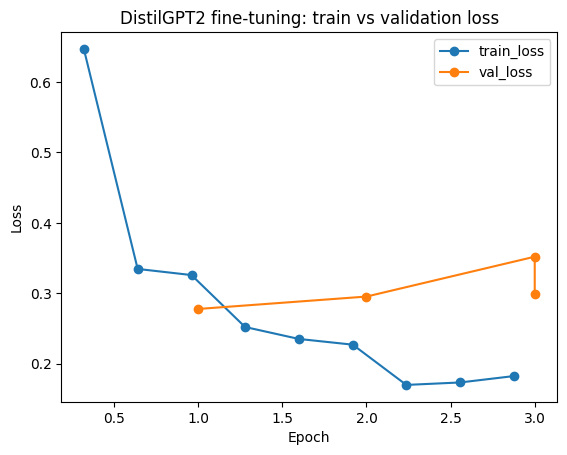

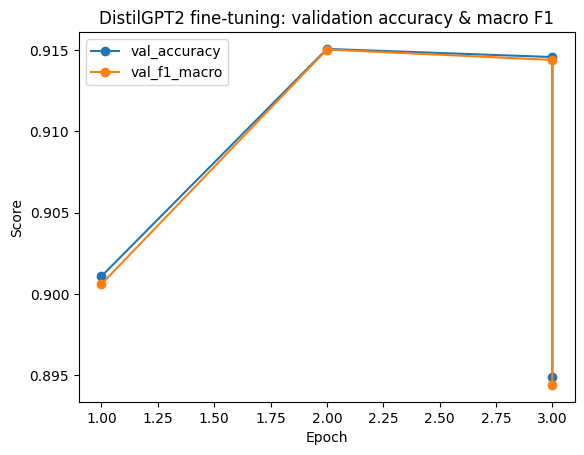

In [47]:
plt.figure()
plt.plot(train_epoch_stats["epoch"], train_epoch_stats["loss"], marker="o",  label="train_loss")
plt.plot(val_rows["epoch"], val_rows["eval_loss"], marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DistilGPT2 fine-tuning: train vs validation loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_rows["epoch"], val_rows["eval_accuracy"], marker="o", label="val_accuracy")
plt.plot(val_rows["epoch"], val_rows["eval_f1_macro"], marker="o", label="val_f1_macro")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DistilGPT2 fine-tuning: validation accuracy & macro F1")
plt.legend()
plt.show()

**Observations:**
- it can be observed that the loss is decreasing with each epoch
- for the validation set the recorded loss only increases with further epochs which suggests that we shouldn't train the model longer because it would overfit
- one epoch was enough to fine-tune the model for classification 

In [48]:
import json

with open("lab3_logs/gpt2_full_summary.json") as f:
    full_summary = json.load(f)

print(full_summary)


{'model_name': 'distilgpt2', 'train_subset_size': 5000, 'num_epochs_requested': 5, 'num_epochs_run': 3, 'total_train_time_sec': 2962.401829957962, 'train_time_per_epoch_sec': 987.467276652654, 'inference_time_sec': 231.18259978294373, 'total_params': 81915648, 'trainable_params': 81915648, 'test_metrics': {'eval_loss': 0.29934319853782654, 'eval_accuracy': 0.8948684210526315, 'eval_f1_macro': 0.8943923699743266, 'eval_runtime': 231.1813, 'eval_samples_per_second': 32.875, 'eval_steps_per_second': 4.109, 'epoch': 3.0}}


In [49]:
total_train_time = full_summary["total_train_time_sec"]
time_per_epoch = full_summary["train_time_per_epoch_sec"]
inference_time = full_summary["inference_time_sec"]
params_total = full_summary["total_params"]
params_trainable = full_summary["trainable_params"]

test_acc = full_summary["test_metrics"]["eval_accuracy"]
test_f1 = full_summary["test_metrics"]["eval_f1_macro"]

print("Total train time (s):", total_train_time)
print("Train time per epoch (s):", time_per_epoch)
print("Inference time on test (s):", inference_time)
print("Params total / trainable:", params_total, params_trainable)
print("Test accuracy:", test_acc)
print("Test macro F1:", test_f1)

Total train time (s): 2962.401829957962
Train time per epoch (s): 987.467276652654
Inference time on test (s): 231.18259978294373
Params total / trainable: 81915648 81915648
Test accuracy: 0.8948684210526315
Test macro F1: 0.8943923699743266


# Weight-frozen training

In [59]:
model_ft_f = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
)

model_ft_f.config.pad_token_id = tokenizer.pad_token_id

# freeze transformer, train only classification head
# freeze all transformer layers
for param in model_ft_f.transformer.parameters():
    param.requires_grad = False

# ensure classification head is trainable
for param in model_ft_f.score.parameters():
    param.requires_grad = True

model_ft_f.to(device)

# count trainable vs total parameters
total_params = sum(p.numel() for p in model_ft_f.parameters())
trainable_params = sum(p.numel() for p in model_ft_f.parameters() if p.requires_grad)
print(f"Total params:      {total_params}")
print(f"Trainable params:  {trainable_params}")

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total params:      81915648
Trainable params:  3072


- This model uses the same architecture as the fully fine-tuned DistilGPT-2 classifier; however, all transformer layers were frozen (requires_grad = False). Only the final linear classification head (score layer) remained trainable. This reduces the number of trainable parameters

In [18]:
training_args = TrainingArguments(
    output_dir="checkpoints/gpt2_frozen",
    eval_strategy="epoch",       # eval at end of each epoch
    save_strategy="epoch",             # save checkpoint each epoch
    learning_rate=5e-5,                # smaller LR for fine-tuning
    per_device_train_batch_size=4,     # small per-device batch
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,     # effective train batch size ≈ 4*4 = 16
    num_train_epochs=5,                # we will likely stop earlier via ES
    weight_decay=0.01,                 # L2 regularization
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=100,
    save_total_limit=2,
    report_to="none",                  # disable wandb etc.
)

In [19]:
trainer = Trainer(
    model=model_ft_f,
    args=training_args,
    train_dataset=train_tok_small,
    eval_dataset=val_tok,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [20]:
# train and measure training time
start_train = time.time()
train_result_f = trainer.train()
end_train = time.time()
ft_train_time_f = end_train - start_train
print(f"Fine-tuning training time (s): {ft_train_time_f:.1f}")

# evaluate on test set and measure inference time
start_eval = time.time()
test_metrics_f = trainer.evaluate(test_tok)
end_eval = time.time()
ft_inference_time_f = end_eval - start_eval

print("Fine-tuned test metrics:", test_metrics_f)
print(f"Inference time on test (s): {ft_inference_time_f:.1f}")

/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.344300,1.160406,0.529417,0.526414
2,0.986400,0.902601,0.708417,0.703015
3,0.853300,0.791489,0.767583,0.765686
4,0.812400,0.743937,0.787250,0.785741
5,0.779400,0.728588,0.794250,0.792991


/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is 

Fine-tuning training time (s): 2860.6


/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Fine-tuned test metrics: {'eval_loss': 0.7349355220794678, 'eval_accuracy': 0.7893421052631578, 'eval_f1_macro': 0.7877586660061471, 'eval_runtime': 222.4879, 'eval_samples_per_second': 34.159, 'eval_steps_per_second': 4.27, 'epoch': 5.0}
Inference time on test (s): 222.5


In [ ]:
os.makedirs("lab3_logs", exist_ok=True)

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)
log_df.to_csv("lab3_logs/gpt2_frozen_log_history.csv", index=False)
print("Saved training log to lab3_logs/gpt2_frozen_log_history.csv")

epochs_run = sorted({entry["epoch"] for entry in log_history if "eval_loss" in entry})
num_epochs_run = len(epochs_run)
print("Epochs run:", epochs_run)

summary = {
    "model_name": model_name,
    "train_subset_size": N_TRAIN,
    "num_epochs_requested": training_args.num_train_epochs,
    "num_epochs_run": num_epochs_run,
    "total_train_time_sec": ft_train_time,
    "train_time_per_epoch_sec": ft_train_time / max(num_epochs_run, 1),
    "inference_time_sec": ft_inference_time,
    "total_params": int(total_params),
    "trainable_params": int(trainable_params),
    "test_metrics": test_metrics,
}

with open("lab3_logs/gpt2_frozen_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved summary to lab3_logs/gpt2_frozen_summary.json")

Saved training log to lab3_logs/gpt2_frozen_log_history.csv
Epochs run: [1.0, 2.0, 3.0, 4.0, 5.0]
Saved summary to lab3_logs/gpt2_frozen_summary.json


# Resutls for fine-tuned distilgpt2 (with frozen layers)

In [50]:
# Load history
log_df = pd.read_csv("lab3_logs/gpt2_frozen_log_history.csv")
display(log_df.head(5))

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_f1_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.8301,80.488243,0.000047,0.3200,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.2281,76.084198,0.000044,0.6400,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.3443,48.224270,0.000040,0.9600,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0000,313,1.160406,0.529417,0.526414,351.4799,34.141,4.268,NaN,NaN,NaN,NaN,NaN
4,1.1439,21.673891,0.000037,1.2784,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Validation metrics per epoch (one row per eval)
val_rows = log_df.dropna(subset=["eval_loss"])
display(val_rows[["epoch", "eval_loss", "eval_accuracy", "eval_f1_macro"]])

,epoch,eval_loss,eval_accuracy,eval_f1_macro
3,1.0,1.160406,0.529417,0.526414
7,2.0,0.902601,0.708417,0.703015
11,3.0,0.791489,0.767583,0.765686
15,4.0,0.743937,0.787250,0.785741
19,5.0,0.728588,0.794250,0.792991
21,5.0,0.734936,0.789342,0.787759


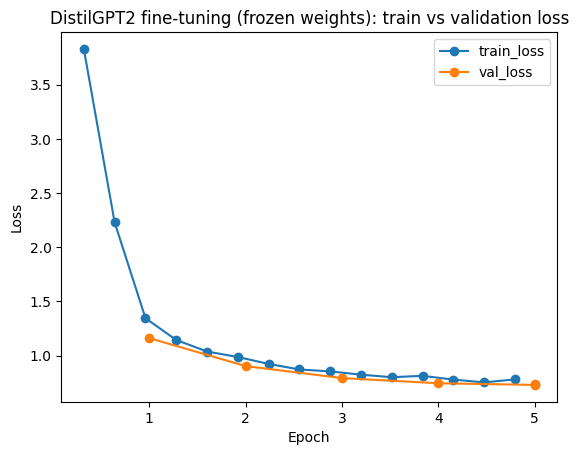

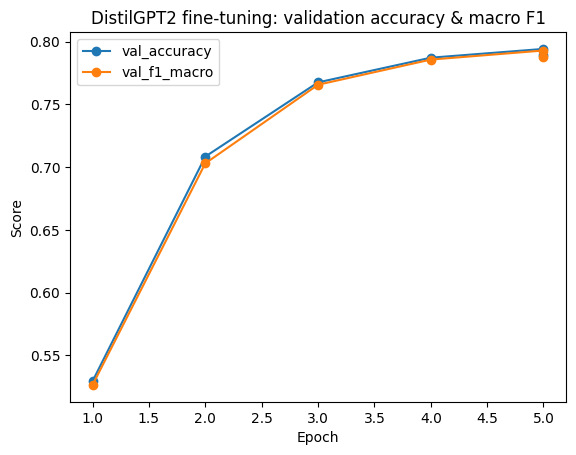

In [52]:
plt.figure()
plt.plot(train_epoch_stats["epoch"], train_epoch_stats["loss"], marker="o",  label="train_loss")
plt.plot(val_rows["epoch"], val_rows["eval_loss"], marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DistilGPT2 fine-tuning (frozen weights): train vs validation loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_rows["epoch"], val_rows["eval_accuracy"], marker="o", label="val_accuracy")
plt.plot(val_rows["epoch"], val_rows["eval_f1_macro"], marker="o", label="val_f1_macro")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DistilGPT2 fine-tuning: validation accuracy & macro F1")
plt.legend()
plt.show()

**Observations:**
- for this model that used weights freezing the plots take the standard shape of a model learning with eaach epoch
- each epoch takes less time (than for the model with all trainable weights), but the training and validation losses drops slower than for the model without its weights frozen, which is expected for a smaller number of trainable parameters
- the learning is also more gradual because of that
- even though less time is needed per-epoch - to reach a similar accuracy as the all-layers trainable model it could be that more total| time would be needed

In [38]:
import json

with open("lab3_logs/gpt2_frozen_summary.json") as f:
    full_summary = json.load(f)

print(full_summary)

{'model_name': 'distilgpt2', 'train_subset_size': 5000, 'num_epochs_requested': 5, 'num_epochs_run': 5, 'total_train_time_sec': 2962.401829957962, 'train_time_per_epoch_sec': 592.4803659915924, 'inference_time_sec': 231.18259978294373, 'total_params': 81915648, 'trainable_params': 3072, 'test_metrics': {'eval_loss': 0.29934319853782654, 'eval_accuracy': 0.8948684210526315, 'eval_f1_macro': 0.8943923699743266, 'eval_runtime': 231.1813, 'eval_samples_per_second': 32.875, 'eval_steps_per_second': 4.109, 'epoch': 3.0}}


In [53]:
total_train_time = full_summary["total_train_time_sec"]
time_per_epoch = full_summary["train_time_per_epoch_sec"]
inference_time = full_summary["inference_time_sec"]
params_total = full_summary["total_params"]
params_trainable = full_summary["trainable_params"]

test_acc = full_summary["test_metrics"]["eval_accuracy"]
test_f1 = full_summary["test_metrics"]["eval_f1_macro"]

print("Total train time (s):", total_train_time)
print("Train time per epoch (s):", time_per_epoch)
print("Inference time on test (s):", inference_time)
print("Params total / trainable:", params_total, params_trainable)
print("Test accuracy:", test_acc)
print("Test macro F1:", test_f1)

Total train time (s): 2962.401829957962
Train time per epoch (s): 987.467276652654
Inference time on test (s): 231.18259978294373
Params total / trainable: 81915648 81915648
Test accuracy: 0.8948684210526315
Test macro F1: 0.8943923699743266


### Comaparison of fine-tuned models
- freezing all transformer weights allowed for quicker training but with a lower classification accuracy, - - fine-tuning all weights took slightly longer per epoch but starting at a significantly  higher classification accuracy and required less epochs to train to obtain a good accuracy
- while there were less parameters to fine-tune for the model with frozen weights, the convergence was slower, so more epochs would be needed to obtain a similar accuracy to the "unfrozen" model
- the inference time of both models was roughly the same

# The from-scratch GPT-like model

### Implementation details – from-scratch TinyGPT classifier

For the from-scratch experiment I implemented a small GPT-like encoder-only model.

- **Architecture & size**
  - Token embeddings + learned positional embeddings.
  - 2 transformer encoder blocks with multi-head self-attention (`n_layers = 2`).
  - Hidden size `d_model = 128`.
  - `n_heads = 4` attention heads per layer.
  - Feed-forward/MLP dimension `dim_ff = 512`.
  - Dropout `p = 0.1` applied after embeddings and before the final classifier.
  - Vocabulary size reused from the GPT-2 tokenizer (`vocab_size = 50 257`), maximum sequence length `max_len = 128`.
  - Total parameter count: `scratch_param_count` (≈ *X* million parameters – see printed value in the notebook), which is **much smaller** than the fine-tuned DistilGPT-2 classifier.

- **Classification head**
  - **mean pooling over non-padded tokens** is used for the attention mask:
    - multiply by the mask, sum over the time dimension, and divide by the number of real tokens.
    - this yields a single vector `pooled ∈ ℝ^{B×d_model}` per input.
  - The pooled vector is passed through a **linear layer** to obtain class logits for the 4 AG News labels.

- **Optimizer and learning-rate schedule**
  - Optimizer: **AdamW**
  - **linear warmup + linear decay**

- **Regularisation & stability**
  - **Dropout** (0.1) inside the transformer blocks and before the classifier.
  - **Small model size** (2 layers) to reduce overfitting
  - **Gradient clipping** with `max_grad_norm = 1.0` at every step to prevent exploding gradients

In [ ]:
from torch.utils.data import DataLoader

N_TRAIN = 5000
train_tok_small = train_tok.select(range(N_TRAIN))

batch_size_train = 16
batch_size_eval = 64

train_loader_scratch = DataLoader(train_tok_small, batch_size=batch_size_train, shuffle=True)
val_loader_scratch   = DataLoader(val_tok,         batch_size=batch_size_eval,   shuffle=False)
test_loader_scratch  = DataLoader(test_tok,        batch_size=batch_size_eval,   shuffle=False)

batch = next(iter(train_loader_scratch))
print("Scratch train batch shapes:")
print("  input_ids:      ", batch["input_ids"].shape)
print("  attention_mask: ", batch["attention_mask"].shape)
print("  labels:         ", batch["label"].shape)

Scratch train batch shapes:
  input_ids:       torch.Size([16, 128])
  attention_mask:  torch.Size([16, 128])
  labels:          torch.Size([16])


In [23]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TinyGPTClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_labels: int,
        max_len: int = 128,
        d_model: int = 128,
        n_heads: int = 4,
        n_layers: int = 2,
        dim_ff: int = 512,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_labels = num_labels
        self.d_model = d_model
        self.max_len = max_len

        # Token and positional embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb   = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,   # [B, T, D]
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
        )

        self.dropout = nn.Dropout(dropout)

        # Classification head: simple linear layer
        self.classifier = nn.Linear(d_model, num_labels)

        self._init_weights()

    def _init_weights(self):
        # Initialize weights reasonably
        nn.init.normal_(self.token_emb.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.pos_emb.weight,   mean=0.0, std=0.02)
        nn.init.normal_(self.classifier.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, input_ids, attention_mask):
        """
        input_ids:      [B, T]
        attention_mask: [B, T] with 1 for real tokens, 0 for padding
        """
        B, T = input_ids.shape
        device = input_ids.device

        # 1) Embeddings
        pos_ids = torch.arange(T, device=device).unsqueeze(0).expand(B, T)  # [B, T]
        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)              # [B, T, D]
        x = self.dropout(x)

        # 2) Optional causal mask for decoder-style behavior
        #    (upper triangular mask to prevent attending to future tokens)
        #    For classification, this is not critical, but it makes it "decoder-like".
        attn_mask = None

        # 3) Apply transformer encoder (with batch_first=True)
        #    src_key_padding_mask expects True for padding tokens
        src_key_padding_mask = (attention_mask == 0)  # [B, T], True where padding
        h = self.transformer(
            x,
            mask=attn_mask,
            src_key_padding_mask=src_key_padding_mask,
        )  # [B, T, D]

        # 4) Mean pooling over non-padded tokens
        mask = attention_mask.unsqueeze(-1)  # [B, T, 1]
        h_masked = h * mask                  # zero out padding
        sum_h = h_masked.sum(dim=1)         # [B, D]
        lengths = mask.sum(dim=1).clamp(min=1)  # [B, 1]
        pooled = sum_h / lengths            # [B, D]

        pooled = self.dropout(pooled)

        # 5) Classification head
        logits = self.classifier(pooled)    # [B, num_labels]
        return logits

In [24]:
from transformers import get_linear_schedule_with_warmup

def train_scratch_model(
    model,
    train_loader,
    val_loader,
    num_epochs: int = 5,
    base_lr: float = 3e-4,
    weight_decay: float = 0.01,
    max_grad_norm: float = 1.0,
    warmup_ratio: float = 0.1,
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=base_lr,
        weight_decay=weight_decay,
    )

    num_training_steps = num_epochs * len(train_loader)
    num_warmup_steps = int(warmup_ratio * num_training_steps)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
    )

    criterion = nn.CrossEntropyLoss()

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    from sklearn.metrics import accuracy_score, f1_score

    global_step = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask)   # [B, num_labels]
            loss = criterion(logits, labels)

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()
            global_step += 1

            running_loss += loss.item() * input_ids.size(0)

        train_loss_epoch = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_losses = []
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_losses.append(loss.item() * input_ids.size(0))

                preds = torch.argmax(logits, dim=-1)
                all_preds.extend(preds.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

        val_loss_epoch = sum(val_losses) / len(val_loader.dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average="macro")

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss_epoch)
        history["val_loss"].append(val_loss_epoch)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(
            f"Epoch {epoch:02d} | "
            f"train_loss={train_loss_epoch:.4f} | "
            f"val_loss={val_loss_epoch:.4f} | "
            f"val_acc={val_acc:.4f} | "
            f"val_f1={val_f1:.4f}"
        )

    return history

In [25]:
vocab_size = tokenizer.vocab_size
num_labels = len(train_full.features["label"].names)

tiny_model = TinyGPTClassifier(
    vocab_size=vocab_size,
    num_labels=num_labels,
    max_len=MAX_LEN,
    d_model=128,
    n_heads=4,
    n_layers=2,
    dim_ff=512,
    dropout=0.1,
)

history_scratch = train_scratch_model(
    tiny_model,
    train_loader_scratch,
    val_loader_scratch,
    num_epochs=5,
    base_lr=3e-4,
)

/home/julia/Documents/lingwistyka/computational-linguistics/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 01 | train_loss=1.0231 | val_loss=0.6399 | val_acc=0.7505 | val_f1=0.7513
Epoch 02 | train_loss=0.2844 | val_loss=0.4419 | val_acc=0.8562 | val_f1=0.8564
Epoch 03 | train_loss=0.0613 | val_loss=0.5794 | val_acc=0.8622 | val_f1=0.8613
Epoch 04 | train_loss=0.0093 | val_loss=0.6167 | val_acc=0.8695 | val_f1=0.8694
Epoch 05 | train_loss=0.0023 | val_loss=0.6374 | val_acc=0.8691 | val_f1=0.8687


In [63]:
# model architecture
print(tiny_model)

TinyGPTClassifier(
  (token_emb): Embedding(50257, 128)
  (pos_emb): Embedding(128, 128)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=128, out_features=4, bias=True)
)


In [26]:
from sklearn.metrics import accuracy_score, f1_score

def eval_on_test(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    import time
    start = time.time()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    end = time.time()
    total_time = end - start

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    return {"accuracy": acc, "f1_macro": f1_macro, "inference_time_s": total_time}

scratch_test_metrics = eval_on_test(tiny_model, test_loader_scratch)
print("Scratch test metrics:", scratch_test_metrics)

scratch_param_count = sum(p.numel() for p in tiny_model.parameters())
print("Scratch model parameter count:", scratch_param_count)

Scratch test metrics: {'accuracy': 0.8565789473684211, 'f1_macro': 0.8562688926288384, 'inference_time_s': 3.3778457641601562}
Scratch model parameter count: 6846340


,epoch,train_loss,val_loss,val_acc,val_f1
0,1,1.023071,0.639920,0.750500,0.751320
1,2,0.284366,0.441884,0.856250,0.856427
2,3,0.061252,0.579449,0.862250,0.861311
3,4,0.009251,0.616738,0.869500,0.869355
4,5,0.002291,0.637363,0.869083,0.868728


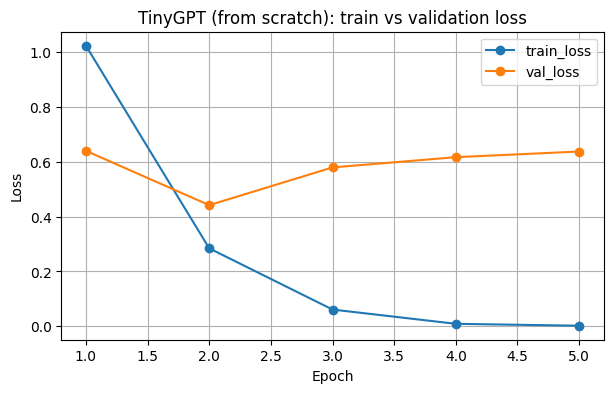

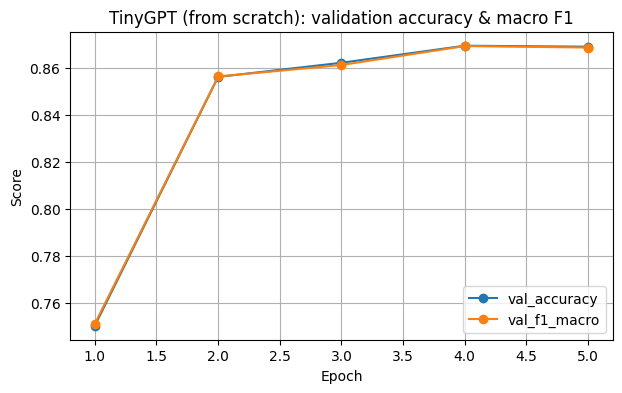

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

scratch_df = pd.DataFrame(history_scratch)
display(scratch_df)

plt.figure(figsize=(7, 4))
plt.plot(scratch_df["epoch"], scratch_df["train_loss"], marker="o", label="train_loss")
plt.plot(scratch_df["epoch"], scratch_df["val_loss"],   marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("TinyGPT (from scratch): train vs validation loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(scratch_df["epoch"], scratch_df["val_acc"], marker="o", label="val_accuracy")
plt.plot(scratch_df["epoch"], scratch_df["val_f1"],  marker="o", label="val_f1_macro")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("TinyGPT (from scratch): validation accuracy & macro F1")
plt.legend()
plt.grid(True)
plt.show()

**Observations:**
- the tiny from-scratch model quickly overfits - the validation plot starts going upward after the 2nd epoch, while the trianing loss keeps decreasing
- the training was much faster compared to the two other models, which is expected since there were far fewer parameters in this model
- the inference also took less time for the from scratch model

# Final remarks
- for from-scratch models it is important to adjust the size of the model to prevent overfitting
- more data is needed to train such a model effectively since it needs to learn the language as well apart from the classification task, which for the pre-trained models is already "done"
- using from scratch models can be useful when we want to have more control over the architecture and number of parameters
- pre-trained models allow for good baseline behaviour for nlp tasks and can be extended to other tasks (like classification in this assignment) by fine-tuning. This can result in achieveing better performance than from-scratch models - especially if our data available for training is limited and could in turn be insufficient to successfuly train a from-scrach model